# HamletMTA Progress Report 2

- David Hadaller
- Angelika Shastapalava
- Sam Mundle 
- Excel Espina

## Project Aims

We will use MTA bus data, Monte Carlo passenger simulation and weather data to create a model that will determine how long a passenger should wait for the next bus, before giving up and chosing an alternative mode of transportation. Our focus thus far has been on one particular bus stop (the southbound M100 on 135th street) in August of 2017. However, this model could be iterated system-wide for every bus stop location. 

The diagram below serves as a reference for our analysis and is explained in more detail in the passages that follow.

![diagram](analysis_diagram.png)

### Monte Carlo Simulation

In our Monte Carlo simulation, we will first assume that there is a uniform probability that a passenger will approach a stop at any given time of day. The reason for this choice is for it's realism (it is a common assumtion among staff analysts at the MTA's operations and planning department) and for it's ease of computation. Later on, we can experiment different ridership behaviors such as a bimodal probability distribution (peak in the early morning and evening for commuters). 

#### Passenger Wait Times (Sam)

We view each day's bus arrivals, at a given bus stop, as points on a timeline. Similarly, each  passenger arival at the bus stop falls also on the day's timeline. Calculating wait times then amounts to finding the difference between the passenger's arrival and the arrival of the very next bus along this timeline. Our goal here is to create a dataset with the time (as in time of day) of approach as the independent variable and the wait time as the dependent variable. This data will serve as the validation set for our model.

#### Bus Time Deltas/headways (David)

For each simulated passenger, we would like to find how crowded a given bus is. To find this, we will simulate many passengers "boarding" busses by assigning a population of $n$ daily passengers a uniform random timestamp between the last and first busses of the day. Buses which feature an abnormally long timedelta (long time interval between current and last bus arrival) will generally be more crowded. Again, the time of day is our independent variable and the number of people on the bus (crowding) is the dependent variable.  This data will serve as the validation set for our model.

### Weather Data (Angelika)

Weather data will include columns for precipitation, wind speed, and visibility for the month of August 2017 in NYC. This data set will be o


### Machine Learning Model (Angelica & Excel)

The feature variables will be include weather data columns and time of day, while the target variables will be the crowding and wait times as experienced by the passengers (to predict what we simulated in the Monte Carlo method step.) Our goal is 

1. to produce predicts the values of the two biased ecdf **charts** (each of which has a time as input and a probability as output, so it won't display the other inputs to the machine learning model, but hopefully considering more variables should help make the predictions more accurate).

2. to produce a general weather-conscious **model** that predicts passenger experience (inspected wait time and inspected crowdedness)

Considerations for this step include, but are not limited to:

- model evaluation (accuracrecall,prediction, lift and all that)
- model type (linear, non linear/ regression/decision tree)


## Data Sources

[MTA Schedules](http://web.mta.info/nyct/service/bus/bklnsch.htm#top) (need to figure out best way to scrape or source better structured data)

[MTA Bus Statistics](https://www.kaggle.com/stoney71/new-york-city-transport-statistics)

[Weather.Gov](https://www.weather.gov/okx/CentralParkHistorical) Data from a weather monitor in central park; Each day, a 1:30 am report holds 24 hours of weather data starting at 12:00 am EST the previous day and the reports look like [this](https://forecast.weather.gov/product.php?site=NWS&issuedby=NYC&product=CLI&format=CI&version=1&glossary=1&highlight=off).

In [1]:
import pandas as pd
import matplotlib.dates
import matplotlib.pyplot as plt
import numpy as np
import datetime, math

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

We then import the csv as a dataframe, because my (David Hadaller) laptop cannot handle importing 'mta_1708.csv', a 1.5 GB file, as Excel did in the cells above.

In [2]:
M100_NICK = pd.read_csv('M100_month_W125_st.csv')
M100_NICK.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'time_delta', 'time_delta_mins', 'time_diff',
       'time_diff_mins'],
      dtype='object')

What are my goals here? Ultimately, I want to have two plots
1. bus crowding (number of passengers per bus) against passenger arrival time for the month of August. 
2. A biased version of the ecdf at the end of `EDA-M100-A.ipynb`. Essentially, a plot of the The cumulative probability of the average daily bus crowding for each day in August.


**note to self:** what should I do about the very first bus ride for each day? It has no time delta because it has no bus precedes it. So how am I to measure crowding? 

Before we begin the simulation, we need to establish what will become the arguments to `numpy.random.uniform(low=0.0, high=1.0, size=None)`. Below, we find the `low` and `high` parameters. That is, we find the first and last bus arrival times for each day.

In [3]:
DailyBusMinMax= M100_NICK.loc[:,['RecordedAtTime']]
splitCol = DailyBusMinMax['RecordedAtTime'].str.split(' ', 1, expand=True).rename(columns={0:'Date', 1:'Time'}) 
DailyBusMinMax['Date']= splitCol['Date'] 

DailyBusMinMax = DailyBusMinMax.drop_duplicates()

DailyBusMax = DailyBusMinMax.groupby('Date').max()
DailyBusMin = DailyBusMinMax.groupby('Date').min()

DailyBusMinMax = pd.merge(left=DailyBusMin, right=DailyBusMax, how='inner',on='Date', suffixes=('Min', 'Max'))
DailyBusMinMax = DailyBusMinMax.rename(columns={'RecordedAtTimeMin':'EarliestBusArrival', 'RecordedAtTimeMax':'LatestBusArrival'})

DailyBusMinMax.reset_index(level=0, inplace=True)
DailyBusMinMax['Date'] = pd.to_datetime(DailyBusMinMax['Date'],format='%Y-%m-%d')
DailyBusMinMax['EarliestBusArrival'] = pd.to_datetime(DailyBusMinMax['EarliestBusArrival'], format='%Y-%m-%d %H:%M:%S')
DailyBusMinMax['LatestBusArrival'] = pd.to_datetime(DailyBusMinMax['LatestBusArrival'], format='%Y-%m-%d %H:%M:%S')

DailyBusMinMax.head()

,Date,EarliestBusArrival,LatestBusArrival
0,2017-08-01,2017-08-01 07:51:49,2017-08-01 18:42:04
1,2017-08-02,2017-08-02 15:54:31,2017-08-02 19:14:42
2,2017-08-03,2017-08-03 13:06:46,2017-08-03 18:17:14
3,2017-08-04,2017-08-04 11:28:26,2017-08-04 21:48:55
4,2017-08-05,2017-08-05 15:10:31,2017-08-05 21:40:50


In the cell below, we take the bus arrival times (when the bus pulls into the stop), the dates associated with each bus arrival time (to help with subsequent merges) and the timedeltas (which we may plot later on) from the original `M100_NICK` data

In [4]:
BusArrivals = M100_NICK.loc[:,['RecordedAtTime','time_delta_mins']]
dates = M100_NICK['RecordedAtTime'].str.split(' ', 1, expand=True).rename(columns={0:'Date'})
BusArrivals.insert(loc=0, column='Date', value=dates['Date'])

BusArrivals = BusArrivals.rename(columns={'RecordedAtTime':'BusArrivalTime'})

# Change Column DataTypes from String (object) to DateTime
BusArrivals['BusArrivalTime'] = pd.to_datetime(BusArrivals['BusArrivalTime'], format='%Y-%m-%d %H:%M:%S')
BusArrivals['Date'] = pd.to_datetime(BusArrivals['Date'], format='%Y-%m-%d %H:%M:%S')
BusArrivals = BusArrivals.drop_duplicates()

BusArrivals.head()

,Date,BusArrivalTime,time_delta_mins
0,2017-08-01,2017-08-01 07:51:49,0
3,2017-08-01,2017-08-01 11:02:25,191
4,2017-08-01,2017-08-01 13:42:23,161
5,2017-08-01,2017-08-01 13:52:39,10
6,2017-08-01,2017-08-01 15:53:02,121


Next, we define a simulation function which gets the `low` and `high` bounds of the uniform distribution from the DailyBusMinMax dataframe and then takes `NumPassengers` for population size of passengers to simulate. 

This simulation function creates a "pivot table" with the Date as pseudo-index and an artificial passengerId for column headers. For each date, the table contains each passenger in NumPassengers simulated bus arrival time (the time at which each passenger approaches the bus stop with the hopes of boarding a bus.)

Of course, the table that results isn't a true pivot table, because the Date column is just another column, rather than a pandas index. Keeping the Date as a column allows us to reference it as a column later on, which will come in handy when we need to return a series of dates.

In [5]:
def passengerSim(DailyBusMinMax, NumPassengers):
    
    #time between the first and last bus arrivals
    dailyDelta = DailyBusMinMax['LatestBusArrival'] - DailyBusMinMax['EarliestBusArrival']
    
    # the first bus arrival
    dailyMin = DailyBusMinMax['EarliestBusArrival']
    
    #number of dates to simulate for
    NumDates = len(DailyBusMinMax.Date)
    
    #this vectorized calculation follows the formula dailyDelta * randomVar + firstBusArrival to choose a random time
        # between the EarliestBusArrival and the LatestBusArrival.
        # this is done for every date and for each passenger in NumPassengers
    pSim = pd.DataFrame(np.random.uniform(0,1,(NumDates,NumPassengers)))
    pSim = pSim.mul(dailyDelta,axis=0)
    pSim = pSim.add(dailyMin,axis=0)
    
    # add a dates column to front of dataframe  
    pSim.insert(loc=0, column='Date', value=DailyBusMinMax['Date'])
    
    return pSim

In [6]:
sim = passengerSim(DailyBusMinMax,1000)
sim.head()

,Date,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,2017-08-01,2017-08-01 17:17:34.782565603,2017-08-01 17:01:54.881360288,2017-08-01 07:59:13.157077108,2017-08-01 16:24:17.348183586,2017-08-01 16:33:46.524179815,2017-08-01 16:35:44.818262181,2017-08-01 15:39:23.105903686,2017-08-01 18:10:34.020810454,2017-08-01 13:32:13.380576978,...,2017-08-01 14:04:51.407417229,2017-08-01 10:00:31.746291022,2017-08-01 09:52:43.932026593,2017-08-01 18:38:00.886548833,2017-08-01 15:56:01.613678568,2017-08-01 08:42:21.159412970,2017-08-01 18:41:31.831876927,2017-08-01 14:28:08.738856727,2017-08-01 14:46:05.906795406,2017-08-01 11:39:11.508804031
1,2017-08-02,2017-08-02 18:13:14.346614027,2017-08-02 16:24:35.507001225,2017-08-02 17:11:50.459475227,2017-08-02 18:40:49.123350212,2017-08-02 17:58:30.226351916,2017-08-02 18:37:08.404155428,2017-08-02 16:12:13.679122495,2017-08-02 17:14:30.436020965,2017-08-02 17:11:20.894771149,...,2017-08-02 18:49:35.985076488,2017-08-02 17:57:52.424349733,2017-08-02 16:09:00.669907886,2017-08-02 17:00:14.796100063,2017-08-02 18:09:43.539407042,2017-08-02 16:57:58.353161853,2017-08-02 17:32:22.117811877,2017-08-02 17:46:45.764346651,2017-08-02 17:40:28.291474890,2017-08-02 17:05:30.783529525
2,2017-08-03,2017-08-03 14:43:17.856647706,2017-08-03 17:50:01.154385162,2017-08-03 17:11:34.020604698,2017-08-03 17:56:54.632746248,2017-08-03 14:46:41.225648222,2017-08-03 17:28:06.797956642,2017-08-03 16:22:54.903114439,2017-08-03 16:55:33.332488165,2017-08-03 17:38:52.061435630,...,2017-08-03 15:33:31.208635466,2017-08-03 17:51:04.573227923,2017-08-03 17:50:55.837824529,2017-08-03 15:09:02.712936523,2017-08-03 15:04:56.378152883,2017-08-03 15:07:09.353830885,2017-08-03 15:54:27.449994115,2017-08-03 17:10:48.946989724,2017-08-03 16:47:46.149983339,2017-08-03 15:32:59.202742931
3,2017-08-04,2017-08-04 11:58:44.835401492,2017-08-04 14:25:49.838671730,2017-08-04 14:59:43.353287336,2017-08-04 13:15:33.221532343,2017-08-04 13:16:29.630852606,2017-08-04 16:27:27.290740400,2017-08-04 15:12:23.014718051,2017-08-04 18:25:42.034279325,2017-08-04 17:01:57.971659856,...,2017-08-04 12:21:14.695471205,2017-08-04 11:44:28.419300097,2017-08-04 19:18:51.143830139,2017-08-04 15:54:30.416826430,2017-08-04 16:19:56.279921057,2017-08-04 18:26:34.463908704,2017-08-04 13:23:03.053504504,2017-08-04 20:19:22.749962665,2017-08-04 21:13:05.796920108,2017-08-04 21:35:08.520323911
4,2017-08-05,2017-08-05 16:09:45.895160001,2017-08-05 17:23:53.053539902,2017-08-05 17:43:34.184671461,2017-08-05 17:05:35.495964577,2017-08-05 15:22:55.065647056,2017-08-05 18:51:12.785113676,2017-08-05 18:24:31.669960475,2017-08-05 15:23:58.896753079,2017-08-05 21:01:32.277590684,...,2017-08-05 17:31:04.933299001,2017-08-05 21:28:44.196813723,2017-08-05 17:08:17.659433026,2017-08-05 19:06:53.058965914,2017-08-05 18:43:45.610697155,2017-08-05 18:31:00.801150221,2017-08-05 19:38:38.955836181,2017-08-05 19:35:30.140169346,2017-08-05 21:09:41.757048043,2017-08-05 17:32:37.468601227


Here, we reorganize the results of the passenger simulation to get a table that has one single `passengerId` column, instead of one column for each passenger. This is will allow us to perform a merge in the following step.

In [7]:
sim = sim.melt(id_vars='Date')
sim = sim.rename(columns={'variable':'passengerId','value':'passengerArrivalTime'})
sim.head()

,Date,passengerId,passengerArrivalTime
0,2017-08-01,0,2017-08-01 17:17:34.782565603
1,2017-08-02,0,2017-08-02 18:13:14.346614027
2,2017-08-03,0,2017-08-03 14:43:17.856647706
3,2017-08-04,0,2017-08-04 11:58:44.835401492
4,2017-08-05,0,2017-08-05 16:09:45.895160001


As promised, we now merge the passenger simulation,`sim` with the bus arrival times, `BusArrivals`. The result of the code below is a lookup table where each passenger arrival time is associated with one bus arrival time; that is to say, the passengers are associated with the bus they board (which will always be the next bus that approaches the stop after they arrive.)

In [8]:
# The powerset of all passenger-bus combinations
busBoarding = pd.merge(right=sim, left=BusArrivals, on='Date', how='inner')

# whittle down previous dataframe to those where passengers board busses that arrive at stop after they do
    # (no going back in time)
busBoarding = busBoarding.loc[busBoarding['BusArrivalTime']>=busBoarding['passengerArrivalTime']]

# the passenger is reasonable and will board the first bus that approaches the stop
busBoarding = busBoarding.groupby(['Date','passengerId','passengerArrivalTime']).first()

# we reset the index to group by a different column in the next step
busBoarding = busBoarding.reset_index().sort_values(['Date','BusArrivalTime','passengerId'])
busBoarding.head()

,Date,passengerId,passengerArrivalTime,BusArrivalTime,time_delta_mins
2,2017-08-01,2,2017-08-01 07:59:13.157077108,2017-08-01 11:02:25,191
11,2017-08-01,11,2017-08-01 10:28:32.546271970,2017-08-01 11:02:25,191
13,2017-08-01,13,2017-08-01 08:03:28.665239901,2017-08-01 11:02:25,191
26,2017-08-01,26,2017-08-01 11:01:42.019286704,2017-08-01 11:02:25,191
30,2017-08-01,30,2017-08-01 09:14:58.994247378,2017-08-01 11:02:25,191


Now, we calcuate the number of people per bus by grouping by `BusArrivalTime` and then counting the number of entries in each group. We then merge this `busCrowding` DataFrame back into our `busBoarding` DataFrame from the previous step to give us a `numPassengersPerBus` column, which tells us exactly how many of our simulated passengers boarded each bus.

In [9]:
busCrowding = busBoarding.groupby(['BusArrivalTime']).count()
busCrowding = pd.DataFrame(busCrowding['passengerId']).rename(columns={'passengerId':'numPassengersPerBus'})
busCrowding.reset_index()

busBoarding = pd.merge(left=busBoarding, right=busCrowding, on='BusArrivalTime', how='inner')
busBoarding.head()


,Date,passengerId,passengerArrivalTime,BusArrivalTime,time_delta_mins,numPassengersPerBus
0,2017-08-01,2,2017-08-01 07:59:13.157077108,2017-08-01 11:02:25,191,279
1,2017-08-01,11,2017-08-01 10:28:32.546271970,2017-08-01 11:02:25,191,279
2,2017-08-01,13,2017-08-01 08:03:28.665239901,2017-08-01 11:02:25,191,279
3,2017-08-01,26,2017-08-01 11:01:42.019286704,2017-08-01 11:02:25,191,279
4,2017-08-01,30,2017-08-01 09:14:58.994247378,2017-08-01 11:02:25,191,279


We now take a few columns of the `busBoarding`data that to plot the relationship between `passengerArrivalTime` and `numPassengersPerBus`.

In [10]:
plotData = busBoarding.loc[:,['passengerArrivalTime','numPassengersPerBus']]
plotData['passengerArrivalTime'] = plotData.passengerArrivalTime.dt.time
plotData.head()

,passengerArrivalTime,numPassengersPerBus
0,07:59:13.157077,279
1,10:28:32.546271,279
2,08:03:28.665239,279
3,11:01:42.019286,279
4,09:14:58.994247,279


Finally, we have our plot.

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.,  90000.]),
 <a list of 11 Text xticklabel objects>)

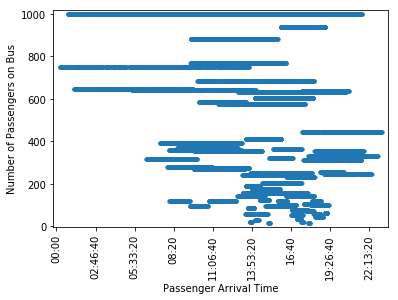

In [11]:
plotData = plotData.sort_values('passengerArrivalTime', ascending=True)
_= plt.plot(plotData['passengerArrivalTime'], plotData['numPassengersPerBus'],'.',linestyle='none')
_ = plt.xlabel('Passenger Arrival Time')
_ = plt.ylabel('Number of Passengers on Bus')
_ = plt.margins(0.02) # Keeps data off plot edges
plt.xticks(rotation='vertical')

Notice that the above plot features a series of points a the 1000 people mark. This signifies that there are busses so crowded that they fit 1000 passengers inside. Clearly there is an innacuracy in the data. The source of the problem is that there is only one bus per day on some days, but the daily population of passengers remains 1000 every day. So far as we can see, there can be two causes for this error: 

1. Some of the bus arrival data is being unnecessarily deleted or is missing; there are no "one-bus-only" days at this stop.
2. The number of passengers should be adapted to the number of busses for each transit day. This would mean the error was setting the daily ridership at a constant of `numPassengers=1000`.

However, once find the source of this error, we will have our "base truth" to help train our models on in the next phase of our project. 